# Test for a two state Bayes Filter wirh Change Point Memory

In [1]:
import numpy as np
import math
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline  

## Create the test data

In [2]:
def genGaussianTwoStateData(length, mean1, mean2, trans_prob):
    data = np.zeros(length)
    state1 = True
    for i in range(0,len(data)):
        if(state1):
            #sample from mean1
            data[i] = np.random.normal(mean1)
            if(np.random.uniform() < trans_prob):
                #change state
                state1 = not state1
        else:
            #sample from mean2
            data[i] = np.random.normal(mean2)
            if(np.random.uniform() < trans_prob):
                #change state
                state1 = not state1
    return data

def genSimpleData():
    data = genGaussianTwoStateData(3000, -4, 4, 0.001)
    return data

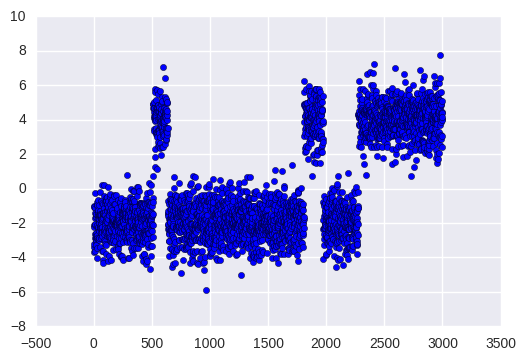

In [56]:
data = genSimpleData()
plt.scatter(range(0,len(data)),data)

## Algorithm

In [6]:
class TwoStateChangePoint(object):
    
    def __init__(self, _theta1=-2, _theta2=4, _z1=0.5, _z2=0.5, _trans_prob=0.001):
        self.theta1 = _theta1
        self.theta2 = _theta2
        self.trans_prob = _trans_prob
        self.z1 = _z1
        self.z2 = _z2
        
        self.prior1 = 0.5
        self.prior2 = 0.5
        
        self.mean = [_theta1, _theta2]
        self.var = [1,1]
        self.sumOfWeights = [0.5,0.5]
        self.weightedSum = [self.mean[0]*self.sumOfWeights[0], self.mean[1]*self.sumOfWeights[1]]   
        self.weightedSumOfSquares = [0,0]

    def updateZUnnorm(self, _w, _likelihoodPriorIntegral):
        return _w * _likelihoodPriorIntegral

    def updateThetaUnnorm(self, _w1, _w2, _likelihoodPriorIntegral, _prior, _likelihood):
        return _prior * (_w1 * _likelihood + _w2 * _likelihoodPriorIntegral)

    def getLikelihood(self, _theta, _x):
        return scipy.stats.norm(_theta,1).pdf(_x)

    def getPrior(self, _theta, _mu, _sigma):
        return scipy.stats.norm(_mu,_sigma).pdf(_theta)

    def getLikelihoodPriorIntegral(self, _theta, _x, _mu, _sigma):
        #print (_sigma**2 * _theta - _mu - _sigma**2 *_x + _theta)
        erf = math.erf((_sigma**2 * _theta - _mu - _sigma**2 *_x + _theta)/
                       (np.sqrt(2) * _sigma * np.sqrt(_sigma**2 + 1)))
        norm = 1/(2 * np.sqrt(2 * np.pi) * np.sqrt(_sigma**2) * np.sqrt(_sigma**2+1))
        return norm * _sigma * np.exp(-(_x - _mu)**2 / (2 *(_sigma**2+1))) * erf

    def getW(self, _z1, _z2, _trans_prob):
        return ((1-_trans_prob) * _z1) + (_trans_prob * _z2)
    
    def getWeights(self, _x, _mean1, _mean2, _var1, _var2):
        probXof1 = scipy.stats.norm(_mean1, _var1).pdf(_x)
        probXof2 = scipy.stats.norm(_mean2, _var2).pdf(_x)
        probSum = probXof1 + probXof2
        return probXof1/probSum, probXof2/probSum
    
    def updateMean(self,_x, _weight, _weightedSum, _sumOfWeights):
        return (_weightedSum+(_weight*_x))/(_sumOfWeights+_weight) if (_sumOfWeights+_weight) > 0.0001 else 1000
    
    def updateVariance(self, _x, _weight, _mean, _sumOfWeights, _weightedSumOfSquares):
        # the variance is calculated too early.
        # after the first iteration the variance for one datum is 0. so there is no probablity to observe another point.
        return (_weightedSumOfSquares+(_weight*(_x-_mean)**2))/(_sumOfWeights+_weight) if _sumOfWeights+_weight > 0.0001 else 1000

    def filterUpdate(self, _x):
        likelihood1 = self.getLikelihood(self.theta1, _x)
        likelihood2 = self.getLikelihood(self.theta2, _x)
        
        print "likelihood", likelihood1,likelihood2

        self.w1 = self.getW(self.z1, self.z2, self.trans_prob)
        self.w2 = self.getW(self.z2, self.z1, self.trans_prob)
        
        print "w", self.w1, self.w2

        lpi1 = self.getLikelihoodPriorIntegral(self.theta1, _x, self.mean[0], self.var[0])
        lpi2 = self.getLikelihoodPriorIntegral(self.theta2, _x, self.mean[1], self.var[1])
        
        print "lpi", lpi1, lpi2
        
        z1Unnorm = self.updateZUnnorm(self.w1, lpi1)
        z2Unnorm = self.updateZUnnorm(self.w2, lpi2)
        
        print "z Unnormed", z1Unnorm, z2Unnorm

        self.z1 = z1Unnorm /(z1Unnorm + z2Unnorm)
        self.z2 = z2Unnorm /(z1Unnorm + z2Unnorm)

        self.theta1 = self.updateThetaUnnorm(self.w1, self.w2, lpi1, self.prior1, likelihood1)
        self.theta2 = self.updateThetaUnnorm(self.w2, self.w1, lpi2, self.prior2, likelihood2)
              
        self.prior1 = self.getPrior(self.theta1, self.mean[0], self.var[0])
        self.prior2 = self.getPrior(self.theta2, self.mean[1], self.var[1])
        
        weights = self.getWeights(_x, self.mean[0], self.mean[1], self.var[0], self.var[1])
        self.mean[0] = self.updateMean(_x, weights[0], self.weightedSum[0], self.sumOfWeights[0])
        self.mean[1] = self.updateMean(_x, weights[1], self.weightedSum[1], self.sumOfWeights[1])
        
        
        self.sumOfWeights[0] += weights[0]
        self.sumOfWeights[1] += weights[1]
        
        self.weightedSum[0] +=_x * weights[0]
        self.weightedSum[1] +=_x * weights[1]
        
        self.weightedSumOfSquares[0] +=(_x - self.mean[0])**2 * weights[0]
        self.weightedSumOfSquares[1] +=(_x - self.mean[1])**2 * weights[1]
        
        return [_x, [self.theta1, self.z1, self.mean[0], self.var[0]], [self.theta2, self.z2, self.mean[1], self.var[1]]]


theta1 = -2
theta2 = 4


BUGS:

lpi for theta computation is wrong. it is $\int P_t(\theta_1) P_{\theta_2}(x_{t+1})d\theta_2$
For now I am using $\int P_t(\theta_1) P_{\theta_1}(x_{t+1})d\theta_1$

In [7]:
algo = TwoStateChangePoint()
print algo.filterUpdate(5)
print algo.filterUpdate(4.6)
#print algo.filterUpdate(4.9)

likelihood 9.13472040836e-12 0.241970724519
w 0.5 0.5
lpi -3.18813339791e-07 -0.0270079252108
z Unnormed -1.59406669896e-07 -0.0135039626054
[5, [-7.9701051267772175e-08, 1.1804297217771822e-05, -1.9999999994714812, 1], [0.053740699827076494, 0.9999881957027823, 4.6666666666582772, 1]]
likelihood 1.01408483476e-05 1.29660604969e-05
w 0.00101178068862 0.998988219311
lpi -2.45611525978e-06 -0.140890763579
z Unnormed -2.48504998888e-09 -0.140748213025
[4.6, [-1.3191992322285335e-07, 1.7655996417901437e-08, -1.9999999948730973, 1], [-2.1472431839295844e-08, 0.99999998234400356, 4.6400000000001382, 1]]


## Test of the mean and variance approximation 

In [4]:
class meanVarTest(object):
    
    def __init__(self, _mean1=2, _mean2=-4):
        self.mean = [_mean1, _mean2]
        self.var = [1,1]
        self.sumOfWeights = [0.5,0.5]
        self.weightedSum = [self.mean[0]*self.sumOfWeights[0], self.mean[1]*self.sumOfWeights[1]]   
        self.weightedSumOfSquares = [0,0]
        
    def getWeights(self, _x, _mean1, _mean2, _var1, _var2):
        probXof1 = scipy.stats.norm(_mean1, _var1).pdf(_x)
        probXof2 = scipy.stats.norm(_mean2, _var2).pdf(_x)
        probSum = probXof1 + probXof2
        return probXof1/probSum, probXof2/probSum
    
    def updateMean(self,_x, _weight, _weightedSum, _sumOfWeights):
        return (_weightedSum+(_weight*_x))/(_sumOfWeights+_weight) if (_sumOfWeights+_weight) > 0.0001 else 1000
    
    def updateVariance(self, _x, _weight, _mean, _sumOfWeights, _weightedSumOfSquares):
        # the variance is calculated too early.
        # after the first iteration the variance for one datum is 0. so there is no probablity to observe another point.
        return (_weightedSumOfSquares+(_weight*(_x-_mean)**2))/(_sumOfWeights+_weight) if _sumOfWeights+_weight > 0.0001 else 1000

    def update(self, _x):
        weights = self.getWeights(_x, self.mean[0], self.mean[1], self.var[0], self.var[1])
        self.mean[0] = self.updateMean(_x, weights[0], self.weightedSum[0], self.sumOfWeights[0])
        self.mean[1] = self.updateMean(_x, weights[1], self.weightedSum[1], self.sumOfWeights[1])
        #self.var[0] = self.updateVariance(_x, weights[0], self.mean[0], self.sumOfWeights[0],
        #                                  self.weightedSumOfSquares[0])
        #self.var[1] = self.updateVariance(_x, weights[1], self.mean[1], self.sumOfWeights[1],
        #                                  self.weightedSumOfSquares[1])
        
        self.sumOfWeights[0] += weights[0]
        self.sumOfWeights[1] += weights[1]
        
        self.weightedSum[0] +=_x * weights[0]
        self.weightedSum[1] +=_x * weights[1]
        
        self.weightedSumOfSquares[0] +=(_x - self.mean[0])**2 * weights[0]
        self.weightedSumOfSquares[1] +=(_x - self.mean[0])**2 * weights[1]
        
        print "sum of weights", self.sumOfWeights
        print "weighted sum", self.weightedSum
        
        
        return (_x, self.mean, self.var)

In [5]:
test = meanVarTest()
print test.update(-3)
print test.update(-4)
print test.update(-3)
print test.update(-4)
print test.update(-3)
#print test.update(-4)
#print test.update(-3)
print test.update(4)
print test.update(4)
print test.update(4)

sum of weights [0.50000614417460221, 1.4999938558253978]
weighted sum [0.99998156747619338, -4.9999815674761932]
(-3, [1.9999385590089862, -3.3333346987110599], [1, 1])
sum of weights [0.50000616320154034, 2.4999938367984598]
weighted sum [0.99998149136844061, -8.9999814913684411]
(-4, [1.9999383306908807, -3.6000014715612223], [1, 1])
sum of weights [0.50001062617537351, 3.4999893738246266]
weighted sum [0.99996810244694123, -11.999968102446942]
(-3, [1.9998937024514611, -3.4285727243034261], [1, 1])
sum of weights [0.50001064411780105, 4.4999893558821995]
weighted sum [0.99996803067723095, -15.999968030677232]
(-4, [1.9998934871507283, -3.5555568614318469], [1, 1])
sum of weights [0.50001499492103207, 5.4999850050789689]
weighted sum [0.99995497826753788, -18.999954978267539]
(-3, [1.999849981349983, -3.4545466870767836], [1, 1])
sum of weights [1.5000149949146966, 5.4999850050853043]
weighted sum [4.9999549782421955, -18.999954978242197]
(4, [3.3332699974286157, -3.4545466870681967]

# Programm after Meeting on the 22.9
With the help of Andreas and Sebastian the filter algorithm should be straight forward to implement.

I should add the formulas here too, after I know if they worl

In [3]:
class TwoClassFilter(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.theta0 = [-2,1]
        self.theta1 = [4,1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        self.t = 0
        self.dataSum = 0
        
    def computeTheta(self, _x, _theta, _weight):
        theta = _theta
        #compute updated var
        theta[1] = 1/(_weight/theta[1] + self.t/1)# maybe find a better way for the likelihood var = 1
        #compute updated mean
        theta[0] = (((_weight * theta[0]) / theta[1]) + self.dataSum/1)/(1/theta[1] + self.t/1)
        return theta
    
    def update(self, _x):
        self.t += 1
        self.dataSum += _x
        #compute probability of x beeing from z[0] or z[1]
        #i.e. the likelihood of _x beeing from z
        #which is P(x|theta) = norm(x|theta[mean], 1)
        unnormZ0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        unnormZ1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        zSum = unnormZ0 + unnormZ1
        self.z = [unnormZ0/zSum, unnormZ1/zSum]
        print "z", self.z
        
        self.theta0 = self.computeTheta(_x, self.theta0, self.z[0])
        self.theta1 = self.computeTheta(_x, self.theta1, self.z[1])
        print "theta0", self.theta0
        print "theta1", self.theta1
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]

In [43]:
f = TwoClassFilter()
f.update(4.0)
f.update(5.0)
f.update(3.0)


z [1.5229979512760349e-08, 0.9999999847700205]
theta0 [1.999999969540041, 0.99999998477002072]
theta1 [3.999999959386721, 0.50000000380749487]
z [0.017986209065416071, 0.98201379093458396]
theta0 [2.2579947689991671, 0.49554352520941314]
theta1 [4.1198533238898438, 0.25226867954874582]
z [0.58704184907857326, 0.41295815092142674]
theta0 [2.4422788472206141, 0.23896904800644961]
theta1 [2.6043045267541465, 0.21565772127285107]


## Version where the theta with the highest likelihood is updated


#### TODO:
* For the computation of $z_t$ the markov transition probability should be incorporated
* For the mean computation I should use two differnet sums. one for z0 and one for z1. Otherwise both theta will aproximate the total mean.

In [10]:
class TwoClassFilterDigital(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [-2,1.1]
        self.theta1 = [2,1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        self.dataCount = [0,0]
        self.dataSum = [0,0]
        
    def computeTheta(self, _x, _theta, _weight, _sum, _count):
        theta = _theta
        #compute updated var
        theta[1] = 1/(_weight/theta[1] + _count/1)# maybe find a better way for the likelihood var = 1
        #compute updated mean
        theta[0] = (((_weight * theta[0]) / theta[1]) + _sum/1)/(1/theta[1] + _count/1)
        return theta
    
    def update(self, _x): 
        #compute probability of x beeing from z[0] or z[1]
        #i.e. the likelihood of _x beeing from z
        #which is P(x|theta) = norm(x|theta[mean], 1)
        likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        unnormZ0 = likelihood0 * (self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1])
        unnormZ1 = likelihood1 * (self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1])
        zSum = unnormZ0 + unnormZ1
        self.z = [unnormZ0/zSum, unnormZ1/zSum]
        #print "z", self.z
        
        if(self.z[0]>self.z[1]):
            self.dataSum[0] += _x
            self.dataCount[0] += 1
            self.theta0 = self.computeTheta(_x, self.theta0, 1, self.dataSum[0], self.dataCount[0])
        else:
            self.dataSum[1] += _x
            self.dataCount[1] += 1
            self.theta1 = self.computeTheta(_x, self.theta1, 1, self.dataSum[1], self.dataCount[1])
        #print "theta0", self.theta0
        #print "theta1", self.theta1
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]
        return self.z, self.theta0, self.theta1

In [14]:
fA = TwoClassFilterDigital()
filterData = []
z0 = []
z1 = []
mean0 = []
mean1 = []
var0 = []
var1 = []
data = genSimpleData()

for i,x in enumerate(data[:]):
    filterData.append(fA.update(x))
    z0.append(filterData[-1][0][0])
    z1.append(filterData[-1][0][1])
    mean0.append(filterData[-1][1][0])
    mean1.append(filterData[-1][2][0])
    var0.append(filterData[-1][1][1])
    var1.append(filterData[-1][2][1])

#plt.scatter(range(0,len(data)),data)

### Plot of $P(z)$

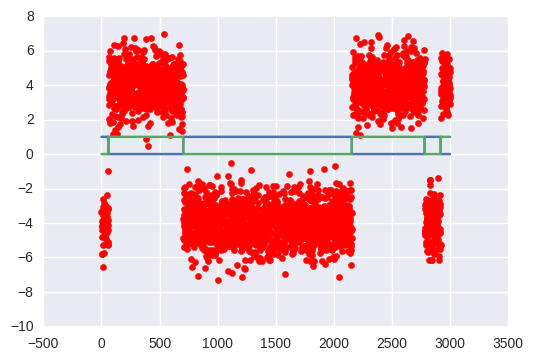

In [17]:
plt.plot(z0)
plt.plot(z1)
plt.scatter(range(0,len(data[:])),data[:], color='red')

### Plot of $\theta$ means

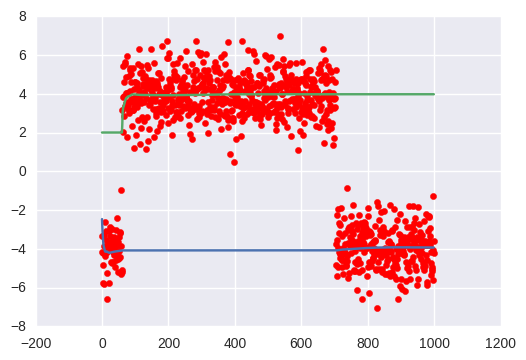

In [18]:
plt.plot(mean0[:1000])
plt.plot(mean1[:1000])
#up = (np.array(mean0[:])-np.array(var0)).tolist()
#down = (np.array(mean0[:])-np.array(var0)).tolist()
#plt.fill_between(range(0,len(data)), up, down)
plt.scatter(range(0,len(data[:1000])),data[:1000], color='red')

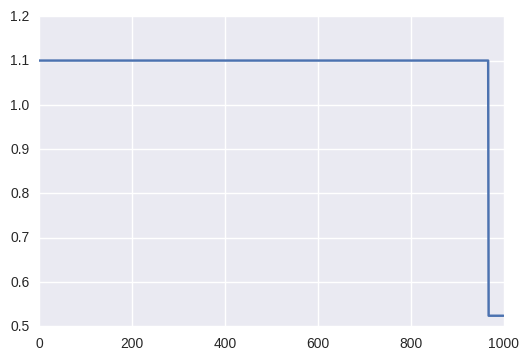

In [9]:
plt.plot(var1[:1000])